In [1]:
!pip install kaggle --upgrade


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devyun","key":"5e2095c648de7d03b7f05a53f92efbfa"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls -1ha kaggle.json


kaggle.json


In [5]:
!kaggle datasets download -d alirakhmaev/ucf-crime-full

100% 24.4G/24.4G [22:13<00:00, 19.5MB/s]
100% 24.4G/24.4G [22:13<00:00, 19.7MB/s]


In [6]:
import zipfile
import os

# 압축 해제할 파일의 경로와 압축 해제될 폴더의 경로
zip_file_path = "/content/ucf-crime-full.zip"
extracted_folder = "/content/ucf_crime_full"

# ZIP 파일 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# 압축 해제된 폴더 목록 출력
extracted_folders = os.listdir(extracted_folder)
print("압축 해제된 폴더 목록:")
for idx, folder in enumerate(extracted_folders):
    print(f"{idx + 1}: {folder}")



압축 해제된 폴더 목록:
1: Vandalism
2: Abuse
3: Burglary
4: RoadAccidents
5: Shooting
6: Stealing
7: Fighting
8: Assault
9: Arson
10: Normal_Videos_for_Event_Recognition
11: Explosion
12: Robbery
13: Shoplifting
14: Arrest



### Data : <a href='https://www.kaggle.com/datasets/alirakhmaev/ucf-crime-full'>ucf-crime-full</a>

In [ ]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
# Error : Your notebook tried to allocate more memory than is available. It has restarted.

# 시퀀스로 공급될 비디오 프레임 수
SEQUENCE_LENGTH = 300

DATASET_DIR = "/content/ucf_crime_full"
CLASSES_LIST = sorted([entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir()])

#### 데이터 설명

- Abuse: 어린이, 노인, 동물 및 여성에 대한 나쁜, 잔인한 또는 폭력적인 행동을 보여주는 비디오가 포함됩니다.
- Burglary: 도둑이 도난을 저지르기 위해 건물이나 집에 들어가는 비디오가 포함됩니다. 이때 사람에 대한 무력한 행동은 포함되지 않습니다.
- Robbery: 도둑이 무력 또는 위협으로 돈을 불법으로 가져가는 비디오가 포함됩니다. 이 비디오에는 총기 사격이 포함되지 않습니다.
- Stealing: 허락 없이 재산이나 돈을 가져가는 사람들을 보여주는 비디오가 포함됩니다. 상점에서 훔치는 경우는 포함되지 않습니다.
- Shooting: 총을 사용하여 누군가를 쏘는 행위를 보여주는 비디오가 포함됩니다.
- Shoplifting: 소비자로서 행동하면서 상점에서 물건을 훔치는 사람들을 보여주는 비디오가 포함됩니다.
- Assault: 누군가에 대한 갑작스럽고 폭력적인 물리적 공격을 보여주는 비디오가 포함됩니다. 이 비디오에서 공격받는 사람은 반격하지 않습니다.
- Fighting: 두 명 이상의 사람들이 서로를 공격하는 모습을 보여주는 비디오가 포함됩니다.
- Arson: 누군가가 재산을 고의로 불태우는 모습을 보여주는 비디오가 포함됩니다.
- Explosion: 무언가가 파열되는 파괴적인 사건을 보여주는 비디오가 포함됩니다. 이 이벤트에는 사람이 의도적으로 불을 지피거나 폭발을 일으키는 비디오는 포함되지 않습니다.
- Arrest: 경찰이 개인들을 체포하는 모습을 보여주는 비디오가 포함됩니다.
- Road Accident: 차량, 보행자 또는 자전거 탑승자와 관련된 교통 사고를 보여주는 비디오가 포함됩니다.
- Vandalism: 공공 또는 사적 재산을 고의적으로 파괴하거나 손상시키는 행위를 보여주는 비디오가 포함됩니다. 이 용어에는 소유자의 허가 없이 모든 재산을 향한 낙서 및 훼손과 같은 재산 손상도 포함됩니다.
- Normal Event: 범죄가 발생하지 않은 비디오가 포함됩니다. 이러한 비디오는 실내(예: 쇼핑몰) 및 실외 장면뿐만 아니라 주간 및 야간 장면을 포함합니다.

In [ ]:
CLASSES_LIST

['Abuse',
 'Arrest',
 'Arson',
 'Assault',
 'Burglary',
 'Explosion',
 'Fighting',
 'Normal_Videos_for_Event_Recognition',
 'RoadAccidents',
 'Robbery',
 'Shooting',
 'Shoplifting',
 'Stealing',
 'Vandalism']

In [ ]:
# 메모리 문제로 3개의 클래스만 학습 
select_class = ['Arson', 'Shooting', 'Vandalism']

In [ ]:
def display_random_video_frames(select_class, dataset_dir, num_classes, rows, cols):

    plt.figure(figsize=(15, 10))

    # Iterate through the selected classes.
    for i, class_name in enumerate(select_class*2, 1):

        video_files_names_list = os.listdir(os.path.join(dataset_dir, class_name))

        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(os.path.join(dataset_dir, class_name, selected_video_file_name))

        _, bgr_frame = video_reader.read()

        video_reader.release()

        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 102, 102), 2)

        plt.subplot(rows, cols, i)
        plt.imshow(rgb_frame)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



#### CCTV 영상 예제

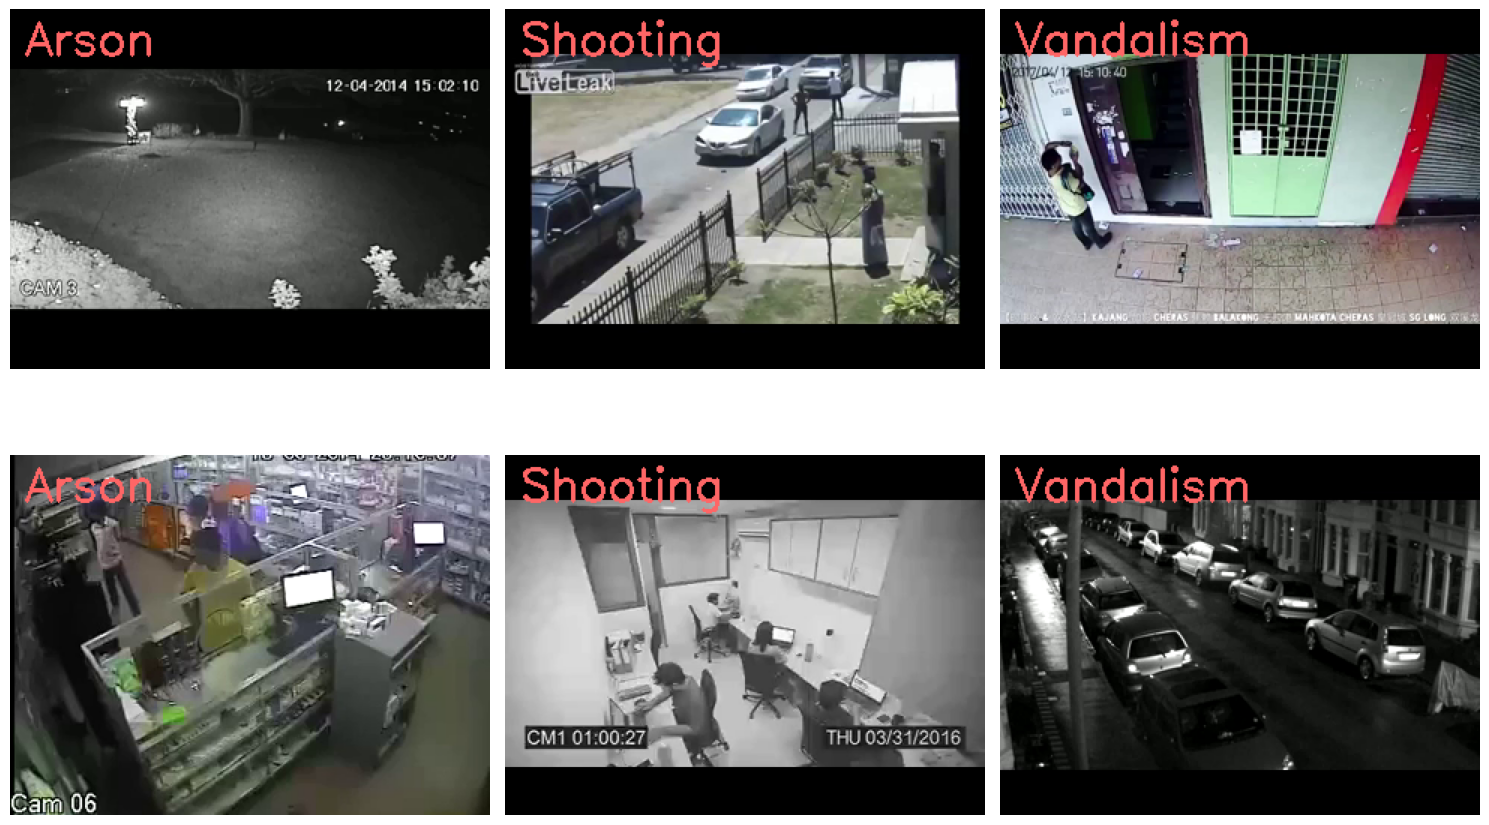

In [ ]:
display_random_video_frames(select_class, extracted_folder, num_classes=6, rows=2, cols=3)


### 동영상 프레임 추출

In [ ]:
def frames_extraction(video_path, max_video_frame_length=2000):

    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_frames_count > max_video_frame_length:
        video_reader.release()
        return frames_list

    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):


        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)


        success, frame = video_reader.read()


        if not success:
            break


        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list



In [ ]:
from tqdm import tqdm

def create_dataset():

    features = []
    labels = []
    video_files_paths = []
    max_length_video_dict = {}

    for class_index, class_name in tqdm(enumerate(select_class)): 
        max_length_video_cnt = 0

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

#         video_count = 0

        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            # 동영상의 시간은 30초부터 1분 30초 까지 다양합니다
            # 동영상의 총 프레임 수가 N 이하인 프레임만 사용합니다
            frames = frames_extraction(video_file_path, 4000)


            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
            else:
                max_length_video_cnt+=1
                max_length_video_dict[class_name] = max_length_video_cnt


    features = np.asarray(features)
    labels = np.array(labels)
    print('Video over max frame   : ',max_length_video_dict)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

0it [00:00, ?it/s]

Extracting Data of Class: Arson


1it [03:49, 229.05s/it]

Extracting Data of Class: Shooting


2it [08:02, 243.67s/it]

Extracting Data of Class: Vandalism


3it [12:06, 242.28s/it]


Video over max frame   :  {'Arson': 14, 'Shooting': 12, 'Vandalism': 12}


features, labels, video_files_paths 데이터 저장

In [ ]:
import pickle

# 데이터를 저장할 파일 경로
output_file_path = "/content/x.pkl"

# 데이터를 하나의 딕셔너리로 묶어준다고 가정합니다.
data = {
    "features": features,
    "labels": labels,
    "video_files_paths": video_files_paths
}

# 데이터 저장
with open(output_file_path, "wb") as output_file:
    pickle.dump(data, output_file)

print("Data saved to", output_file_path)

Data saved to /content/feature_label_data.pkl


In [1]:

with open(output_file_path, "rb") as input_file:
    loaded_data = pickle.load(input_file)

loaded_features = loaded_data["features"]
loaded_labels = loaded_data["labels"]
loaded_video_files_paths = loaded_data["video_files_paths"]




In [ ]:
one_hot_encoded_labels = to_categorical(loaded_labels)

# Split the Data into Train ( 80% ) and Test Set ( 20% )
features_train, features_test, labels_train, labels_test = train_test_split(loaded_features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

CNN은 네트워크에 단시간 정보를 구현할 수 있지만 전체 데이터의 시간 정보를 모델링하기는 어렵다. 반면 LSTM은 장기간 데이터 모델링에 적합하지만 공간정보를 학습하기 어렵다. 따라서 행동 특성을 추출하고 시간 매커니즘을 파악하기 위해 두 방법을 결합한 LRCN 모델을 사용한다.

### LRCN (Long-Term Recurrent Convolutional Networks)

- LRCN은 합성곱(Convolutional) 레이어와 장기적인 시간적 연속성을 다루기 위한 순환(RNN) 레이어를 조합한 구조이다. 
- 연속적인 이미지로 이루어진 비디오 데이터를 처리하는데 사용되는 모델이며,  비디오에서 나타나는 변화를 포착하고 시간적 패턴을 학습하여 영상 데이터를 분류하는 역할을 수행합니다.
- 일련의 이미지 프레임을 입력으로 받아들이고, 이를 순차적으로 처리하여 비디오의 특징을 추출합니다.

<img src = 'https://velog.velcdn.com/images/jyunxx/post/604e38c4-4b11-4bf1-af00-46994fe35737/image.png'>


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout


### LRCN 모델 생성

In [ ]:
def create_LRCN_model():


    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(select_class), activation = 'softmax'))


    model.summary()

    return model

Convolutional Neural Network (CNN)을 이용해 각 프레임에서 공간적인 특징을 추출하고, 그 다음 TimeDistributed를 이용하여 시간적인 연속성을 유지하면서 각 프레임에 적용합니다.

그리고 LSTM을 이용하여 이전 프레임의 정보를 현재 프레임에 전달하면서 시퀀스의 패턴을 학습합니다.

마지막으로는 LSTM의 출력을 기반으로 분류를 수행하는 Fully Connected Layer가 추가되어 클래스를 예측합니다.

In [ ]:
LRCN_model = create_LRCN_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 200, 64, 64, 16)  448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 200, 16, 16, 16)  0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 200, 16, 16, 16)  0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 200, 16, 16, 32)  4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 200, 4, 4, 32)    0

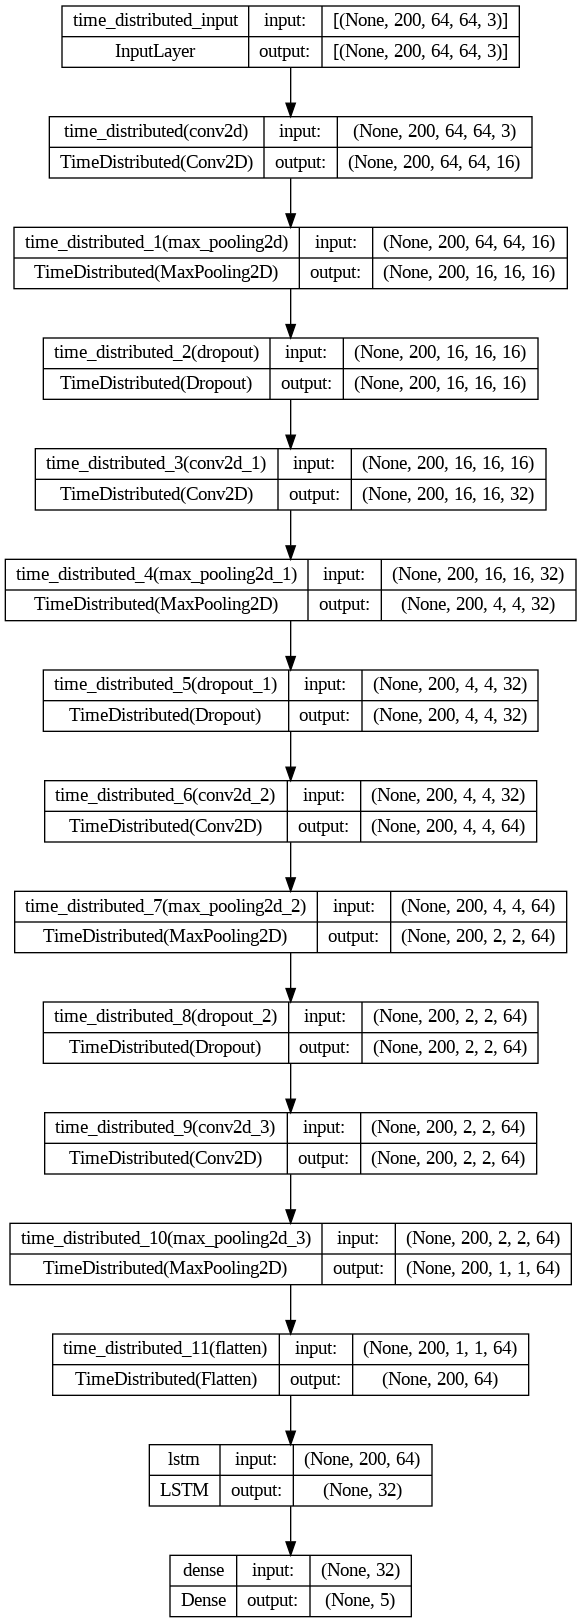

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### 모델 훈련

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights = True)

#  loss function, optimizer 
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
23/23 [==============================] - 5s 84ms/step - loss: 1.0780 - accuracy: 0.5109 - val_loss: 1.7273 - val_accuracy: 0.2917
Epoch 2/100
23/23 [==============================] - 1s 48ms/step - loss: 1.0293 - accuracy: 0.5761 - val_loss: 1.6375 - val_accuracy: 0.2500
Epoch 3/100
23/23 [==============================] - 1s 48ms/step - loss: 0.9112 - accuracy: 0.6087 - val_loss: 1.7288 - val_accuracy: 0.3333
Epoch 4/100
23/23 [==============================] - 1s 48ms/step - loss: 0.8408 - accuracy: 0.6739 - val_loss: 1.7742 - val_accuracy: 0.2500
Epoch 5/100
23/23 [==============================] - 1s 48ms/step - loss: 0.8813 - accuracy: 0.6087 - val_loss: 1.8282 - val_accuracy: 0.3333
Epoch 6/100
23/23 [==============================] - 1s 47ms/step - loss: 0.7584 - accuracy: 0.7174 - val_loss: 1.8650 - val_accuracy: 0.2917
Epoch 7/100
23/23 [==============================] - 1s 48ms/step - loss: 0.6264 - accuracy: 0.7609 - val_loss: 1.9307 - val_accuracy: 0.3750
Epoch 

### TEST

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 1s 1s/step - loss: 1.5420 - accuracy: 0.3103


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

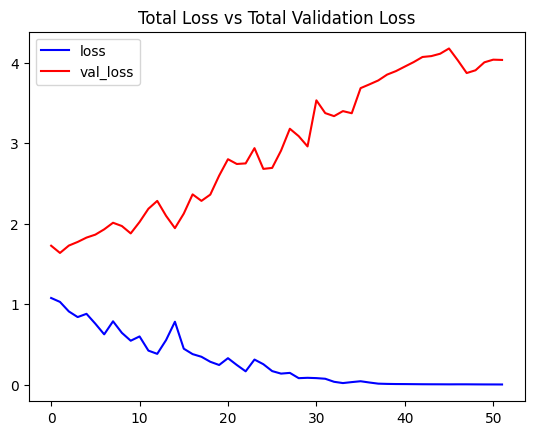

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

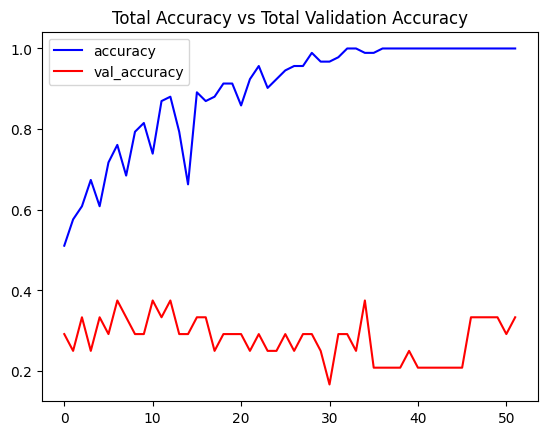

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### 모델 성능 상승을 위한 방법

- 더 깊은 CNN 레이어 추가: CNN 레이어를 더 깊게 쌓거나, 더 많은 필터를 사용하여 이미지의 특징을 더 잘 추출하도록 할 수 있습니다. 하지만 레이어를 깊게 쌓을 때는 과적합에 주의해야 합니다.

- LSTM 레이어 수정: LSTM 레이어의 유닛 수를 조정하거나, 레이어를 여러 개 쌓아보는 등의 변경을 통해 모델의 표현 능력을 높일 수 있습니다.

- 정규화와 드롭아웃 사용: CNN과 LSTM 레이어 사이에 배치 정규화나 드롭아웃과 같은 regularization 기법을 추가하여 과적합을 줄일 수 있습니다.

- 다양한 옵티마이저 시도: 모델의 수렴 속도와 성능은 사용하는 옵티마이저에 따라 달라질 수 있습니다. Adam이나 RMSProp 등의 다양한 옵티마이저를 시도해보며 성능을 확인할 수 있습니다.

- 데이터 확장: 데이터 증강(data augmentation) 기법을 활용하여 데이터셋을 더 다양하게 만들어 모델의 일반화 성능을 향상시킬 수 있습니다.

- 미세 조정 (Fine-tuning): 사전 훈련된 CNN 모델을 사용하고 있다면, 이 모델의 일부 레이어를 고정시키고 일부 레이어만 훈련시켜 모델을 조정할 수 있습니다.

- 하이퍼파라미터 조정: 학습률, 배치 크기, 에포크 수 등과 같은 하이퍼파라미터들을 조정하며 최적의 조합을 찾아볼 수 있습니다.

- 다른 모델 아키텍처 시도: LSTM 외에도 다른 RNN 계열 모델이나, Transformer와 같은 최신 아키텍처를 시도하여 성능을 비교해 볼 수 있습니다.

- 앙상블: 여러 모델의 예측을 결합하여 더 강력한 모델을 생성하는 앙상블을 시도할 수 있습니다.